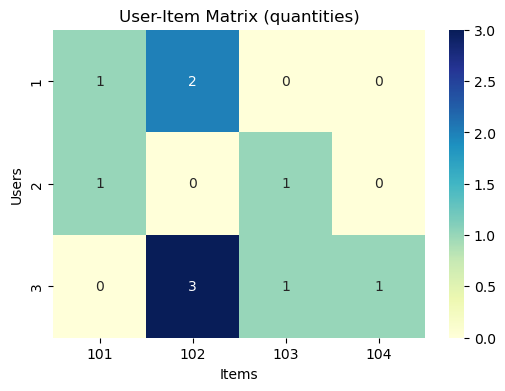

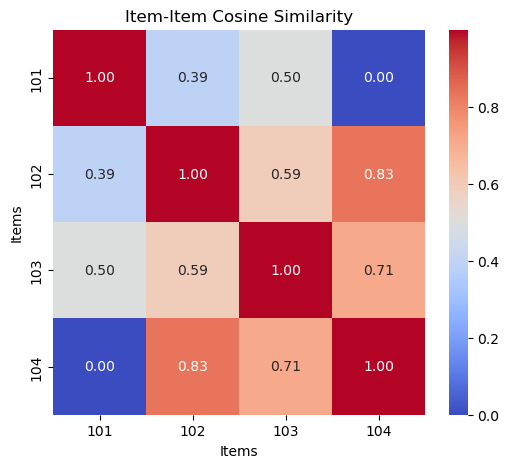

C:\Users\lenovo\AppData\Local\Temp\ipykernel_29600\1146689833.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores.index.astype(str), y=scores.values, palette="viridis")


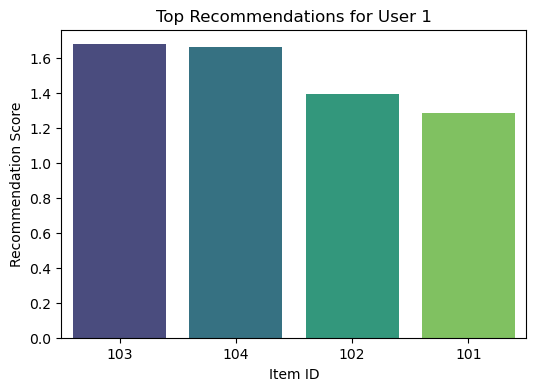

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

orders = pd.DataFrame({
    "user_id": [1, 1, 2, 2, 3, 3, 3],
    "item_id": [101, 102, 101, 103, 102, 103, 104],
    "quantity": [1, 2, 1, 1, 3, 1, 1]
})

def user_item_matrix(orders: pd.DataFrame) -> pd.DataFrame:
    mat = orders.pivot_table(
        index="user_id",
        columns="item_id",
        values="quantity",
        aggfunc="sum",
        fill_value=0
    ).astype(float)
    return mat

mat = user_item_matrix(orders)


def _cosine_similarity(matrix: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(matrix, axis=0, keepdims=True) + 1e-9
    normalized = matrix / norms
    return normalized.T @ normalized

def item_similarity(mat: pd.DataFrame):
    sim = _cosine_similarity(mat.values)
    return pd.DataFrame(sim, index=mat.columns, columns=mat.columns)

sim_matrix = item_similarity(mat)


def cf_scores_for_user(user_id: int, top_k: int | None = None) -> pd.Series:
    sim = item_similarity(mat)
    user_vector = mat.loc[user_id]
    weights = user_vector.values
    if np.all(weights == 0):
        return pd.Series(dtype=float)

    scores = sim.values @ weights
    scores = pd.Series(scores, index=mat.columns)
    scores -= user_vector * 0.5
    scores = scores.clip(lower=0)

    if top_k:
        scores = scores.nlargest(top_k)
    return scores


plt.figure(figsize=(6,4))
sns.heatmap(mat, annot=True, cmap="YlGnBu", cbar=True)
plt.title("User-Item Matrix (quantities)")
plt.ylabel("Users")
plt.xlabel("Items")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(sim_matrix, annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Item-Item Cosine Similarity")
plt.ylabel("Items")
plt.xlabel("Items")
plt.show()


scores = cf_scores_for_user(user_id, top_k=5)

plt.figure(figsize=(6,4))
sns.barplot(x=scores.index.astype(str), y=scores.values, palette="viridis")
plt.title(f"Top Recommendations for User {user_id}")
plt.xlabel("Item ID")
plt.ylabel("Recommendation Score")
plt.show()



###  Collaborative Filtering 
  

1. **User–Item Matrix**  
$M_{u,i} = \text{orders of item } i \text{ by user } u$

2. **Add Customization Weight**  
$M_{u,i} = M_{u,i} + (\text{modifications}) \times \alpha$  
where $\alpha = 0.2$ (controls impact of added/removed ingredients)

3. **Cosine Similarity**  
$\text{sim}(i,j) = \frac{M_{\ast,i} \cdot M_{\ast,j}}{\|M_{\ast,i}\| \cdot \|M_{\ast,j}\|}$

4. **Recommendation Score**  
$\text{score}_{u,i} = \sum_j \text{sim}(i,j) \cdot M_{u,j}$
